In [1]:
import h5py
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 

from scipy import signal
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel

from matplotlib import rc

#rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


## Functions for reading in waveforms, and ramp function for tapering

In [9]:
def ReadExtrapolatedMode(file, mode = (2,-2), order = 2, mass = 68 * const.M_sun, radius = 400000 * const.kpc):
    """ Read in an extrapolated SXS-format gravitational waveform mode """

    l = mode[0]
    m = mode[1]
    f = h5py.File(file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    time = time - time[0]
    
    ## Combine the real and imaginary parts of the data
    re_adj = re*const.G*mass/((const.c)**2*radius)
    im_adj = im*const.G*mass/((const.c)**2*radius)
    time_adj = time*mass*const.G/(const.c**3)
    
    #dt = 1/len(time_adj)
     
    dt = 1/2048
    times = np.arange(time_adj[0].value, time_adj[-1].value, dt)
    cs_r = CubicSpline(time_adj,re_adj)
    cs_i = CubicSpline(time_adj,im_adj)
    
    real = cs_r(times)
    imag = cs_i(times)
    
    #return time, re, im, dt
    return times, real, imag, dt

def Ramp(time, t_s, t_r):
    """ Ramp function for tapering the waveform"""
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    

## Read in and plot data, apply tapering

In [14]:
rh_file = "/home/maria.okounkova/BeyondGRAnalysis/Waveforms_22/Lev2/rhOverM_Asymptotic_GeometricUnits_CoM.h5"
t, re, img, dt = ReadExtrapolatedMode(rh_file, mode = (3,3), order = 2,  mass = 68 * const.M_sun)

[0.03222656 0.03320312 0.03320312 0.03320312 0.03222656
 0.03222656 0.03125    0.03125    0.03027344 0.02978516
 0.02880859 0.02832031 0.02783203 0.02734375 0.02636719
 0.02587891 0.02490234 0.02441406 0.0234375  0.02246094
 0.02197266 0.02099609 0.02050781 0.01904297 0.01855469
 0.01757812 0.01611328 0.01513672 0.01367188 0.01269531
 0.01123047 0.00927734 0.00732422 0.00488281 0.00341797
 0.00292969 0.00244141 0.00244141 0.00244141 0.00244141
 0.00244141 0.00244141 0.00244141 0.00195312 0.00244141
 0.00244141 0.00244141 0.00244141 0.00244141 0.00341797
 0.00390625]
[ 31.03030303  30.11764706  30.11764706  30.11764706
  31.03030303  31.03030303  32.          32.
  33.03225806  33.57377049  34.71186441  35.31034483
  35.92982456  36.57142857  37.92592593  38.64150943
  40.15686275  40.96        42.66666667  44.52173913
  45.51111111  47.62790698  48.76190476  52.51282051
  53.89473684  56.88888889  62.06060606  66.06451613
  73.14285714  78.76923077  89.04347826 107.78947368
 136.533333

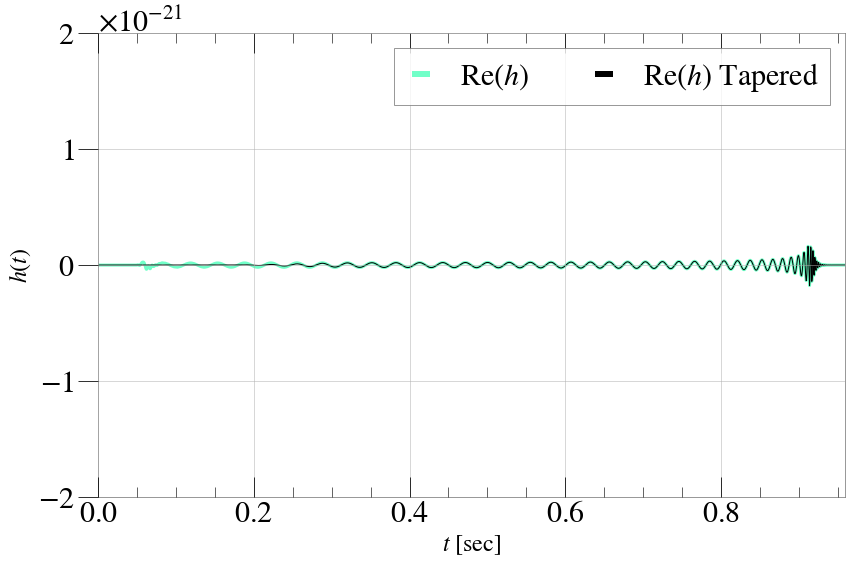

In [15]:
## Plot the data and apply the ramp function
from scipy.signal import argrelextrema
plt.figure(figsize=(12, 8))

ramp = np.array([Ramp(time, 0.1, 0.3) for time in t])

plt.plot(t, re, '-', lw=3.0, color='#71ffc8', label=r'$\mathrm{Re}(h)$')
plt.plot(t, re * ramp, lw=1.0, color='black', label='$\mathrm{Re}(h)$ Tapered')
index = argrelextrema(re * ramp, np.greater)
times = t[index]
diff = times[1:] - times[:-1]
print(diff)
print(diff**-1)
#for i in index[0]:
#    plt.axvline(t[i])
    
    
plt.xlim(min(t), max(t))
plt.ylim(-2e-21, 2e-21)
plt.legend(ncol=2, fontsize=30)
plt.xlabel(r'$t$ [sec]')
plt.ylabel(r'$h(t)$')
plt.tight_layout()
plt.savefig('Taper.pdf')
plt.show()

## actually apply the ramp function
re = re * ramp
img = img * ramp

## Compute h_plus and h_cross, shift data to desired gps time

In [15]:
## Compute and shift h_plus and h_cross
t_gps = 1126259462.4107006 ## desired gps time
peak_time_in_segment = 8.0 ## how late in the segment do we want the peak to occur?
segment_length = 16.0 ## how long do we want the segment to be?
sample_rate = 2048

h_plus = re + img
h_cross = re - img

## shift and pad the waveform before we do anything else
t_peak = t[np.argmax(h_plus**2 + h_cross**2)]

## want the peak time to correspond to 6 seconds
shift_amount = (peak_time_in_segment - t_peak)
start_pad = int(shift_amount * 2048)
end_pad = int(sample_rate*segment_length - len(h_plus) - start_pad)

h_plus = np.pad(h_plus, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
h_cross = np.pad(h_cross, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
t = np.arange(0., segment_length, dt) + t_gps - peak_time_in_segment


t_peak =  1126259462.4107006


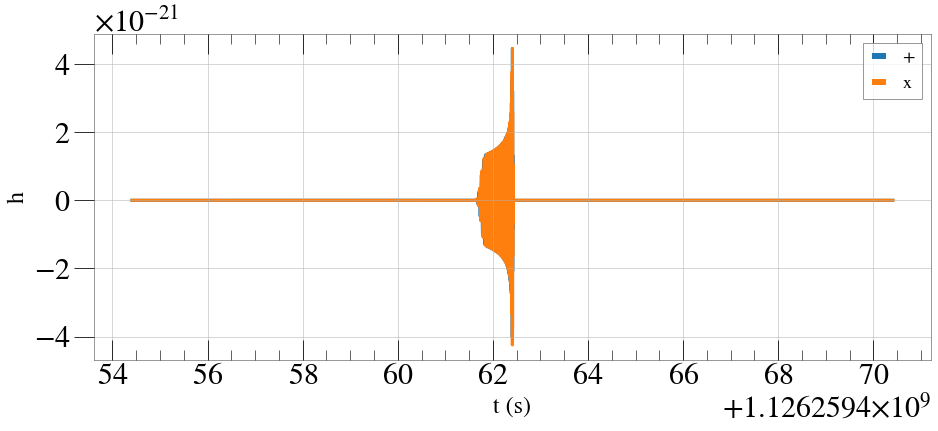

In [16]:
plt.figure(figsize = ([15, 6]))
plt.plot(t, h_plus, label = '+')
plt.plot(t, h_cross, label = 'x')
plt.xlabel('t (s)')
plt.ylabel('h')
plt.legend()
plt.plot

print("t_peak = ",t[np.argmax(h_plus**2 + h_cross**2)])

## Project data to detectors

In [18]:
d_H1 = Detector("H1")
d_L1 = Detector("L1")

In [19]:
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    #The time delay of the signal between the detectors
    t_delay = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    
    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay)
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay
    print(t_delay)
    
    return h_H1, h_L1, time_H1, time_L1

In [20]:
strainH, strainL, timeH, timeL = ProjectToDetectors(ra=4.7614763656, dec=-0.531780006467, pol=0.310886773011, \
                                                    t0=t_gps, plus=h_plus, cross=h_cross, time=t)

0.005239059443450027


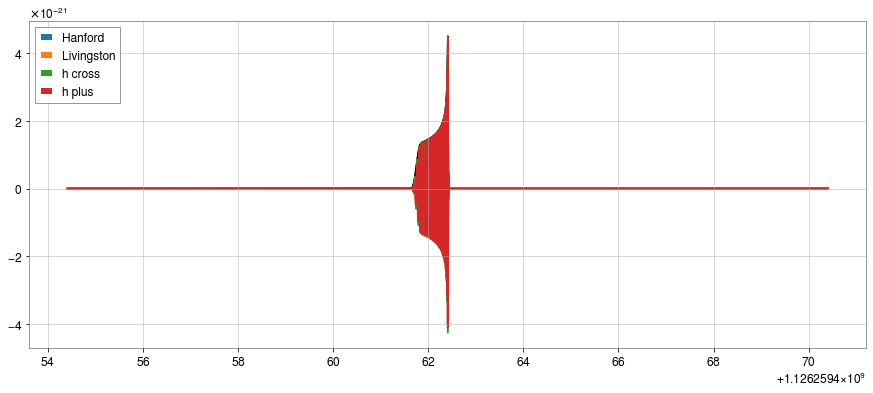

In [21]:
plt.figure(figsize = ([15, 6]))
plt.plot(timeH, strainH, label = "Hanford")
plt.plot(timeL, strainL, label = "Livingston")
plt.plot(t, np.sqrt(h_cross**2 + h_plus**2), color='black')
plt.plot(t, np.sqrt(h_cross**2 + h_plus**2), color='black')
plt.plot(t, h_cross, label='h cross')
plt.plot(t, h_plus, label='h plus')
plt.legend(loc = 2)
plt.show()

## Save the projected data as TimeSeries objects and write frames files

In [22]:
H1_padded = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
L1_padded = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")
H1_padded.write("H1_GR.gwf")
L1_padded.write("L1_GR.gwf")

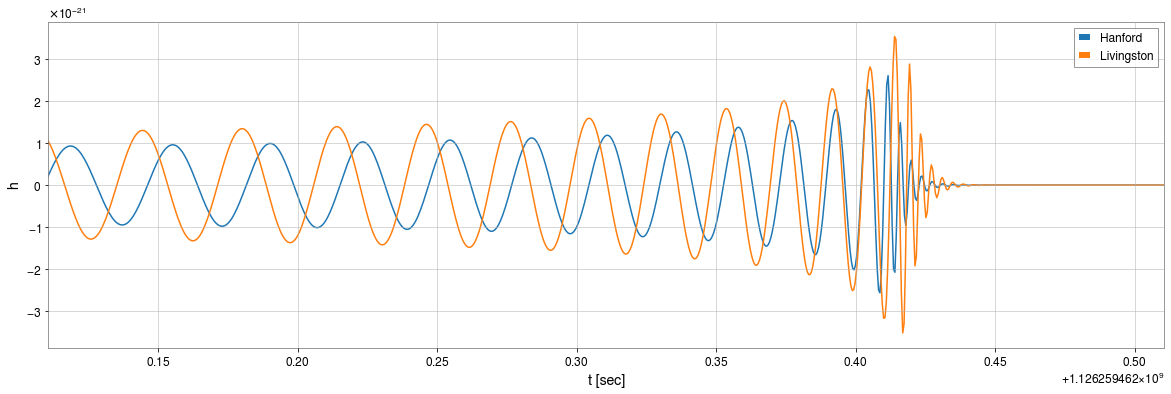

In [23]:
plt.figure(figsize = ([20, 6]))
plt.plot(H1_padded.times.value, H1_padded.value, label = 'Hanford')
plt.plot(L1_padded.times.value, L1_padded.value, label = 'Livingston')
plt.ylabel('h')
plt.xlabel('t [sec]')
plt.xlim(t_gps - 0.3, t_gps + 0.1)
plt.legend()
plt.show()

## Read in TimeSeries from frames file and plot

In [42]:
def PlotSeriesFromFile(file, plot_fft = False):
    """ """

    s1 = TimeSeries.read(source = file, channel="H1:LDAS_STRAIN")
    t1 = s1.times
    t_peak = t1[np.argmax(np.absolute(s1))]
    print("t_peak = ",t_peak)
    print(t_gps)

    plt.figure(figsize=(10, 8))
    
    if plot_fft:
        fft = s1.fft()
        plt.plot(fft.frequencies, np.abs(fft.value))
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('h')
        plt.xlim(0, 400)
        plt.yscale('log')
        plt.axvline(25, color='black', label='25 Hz')
        plt.legend()
        plt.ylim(1e-25, 2e-21)
    
    else:
        plt.plot(t1, s1, label='H1', color='orange')
        plt.xlabel('Time [sec]')
        plt.legend()
        plt.ylabel('h')
        
    plt.show()
    

t_peak =  1126259462.4116771 s
1126259462.4107006


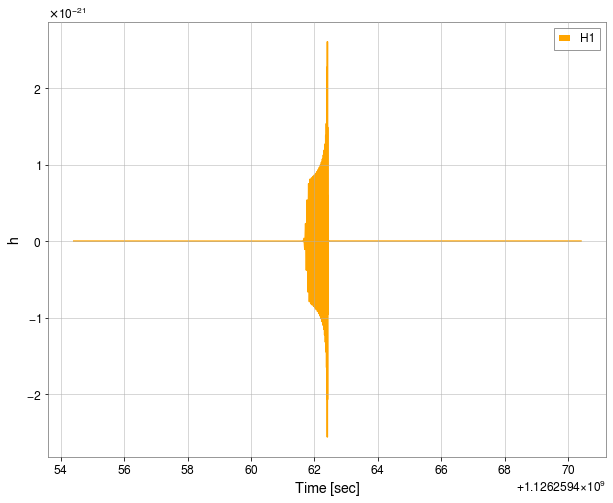

In [43]:
#PlotSeriesFromFile("/home/maria.okounkova/public_html/SimplerFrames/H1_GR.gwf", plot_fft = False)
PlotSeriesFromFile("/home/maria.okounkova/BeyondGRAnalysis/Waveforms_22/dCS_0p0_Lev2/H-H1HWINJ_dCS_0p0.gwf")
